In [1]:
using Pkg

Pkg.activate("..")

# using LinearAlgebra
# using Distributions
using Random
using StatsBase


# using ForwardDiff
using LambertW
using Roots 

using Graphs
using CairoMakie
using GraphMakie
using JLD2

# using DelimitedFiles

include("../Code/MiNet//MiNet.jl")

  Activating project at `~/Projects/MiNet`
[ Info: Precompiling Graphs [86223c79-3864-5bf0-83f7-82e725a168b6]
Precompiling ConstructionBaseStaticArraysExt
  ✓ ConstructionBase → ConstructionBaseStaticArraysExt
  1 dependency successfully precompiled in 7 seconds. 6 already precompiled.
[ Info: Precompiling ConstructionBaseStaticArraysExt [8497ba20-d017-5d93-8a79-2639523b7219]
┌ Warning: Module StaticArrays with build ID fafbfcfd-a6ee-97c3-0000-00182e1544ab is missing from the cache.
│ This may mean StaticArrays [90137ffa-7385-5640-81b9-e52037218182] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing ConstructionBaseStaticArraysExt [8497ba20-d017-5d93-8a79-2639523b7219].
Precompiling AccessorsStaticArraysExt
  ✓ Accessors → AccessorsStaticArraysExt
  ✓ StructArrays → StructArraysStaticArraysExt
  2 dependencies successfully precompiled in 1 seconds. 26 already precompiled.

Main.MiNet

In [2]:
function plot_bifurcation!(ax, xvec, yvec; args...)
    if any(length.(yvec) .== 3)
        b_order = 0
        #if not all in the multistable
        if !all(length(yvec) .== 3)
            b_order = minimum(yvec[end]) < maximum(yvec[1]) ? :hl : :lh 
        else
            b_order = yvec[end][2] < yvec[1][2] ? :hl : :lh
        end
        
        #plot branches
        if b_order == :hl
            inde = findlast(length.(yvec) .== 3)
            lines!(ax, xvec[1:inde], maximum.(yvec[1:inde]); args...)
            
            inds = findfirst(length.(yvec) .== 3)
            lines!(ax, xvec[inds: end], minimum.(yvec[inds:end]); args...)
        
            lines!(ax, xvec[inds:(inde)], [y[2] for y = yvec[inds: (inde) ]]; linestyle = :dash, args...)
        elseif b_order == :lh
             inde = findlast(length.(yvec) .== 3)
            lines!(ax, xvec[1:inde], minimum.(yvec[1:inde]); args...)
            
            inds = findfirst(length.(yvec) .== 3)
            lines!(ax, xvec[inds: end], maximum.(yvec[inds:end]); args...)
        
            lines!(ax, xvec[inds:(inde)], [y[2] for y = yvec[inds: (inde) ]]; linestyle = :dash, args...)
        end
    else
        lines!(ax, xvec, [y[1] for y = yvec]; args...)
    end
end

plot_bifurcation! (generic function with 1 method)

# Introduction

# Poisson Graphs

In [3]:
#load results
res = load("../Results/JLD2/fig_1.jld2")
sim_mat = res["sim"]
pred_mat = res["pred"]
b0_sols,c0_sols = res["phase"]

LoadError: ArgumentError: No file exists at given path: ../Results/JLD2/fig_1.jld2

In [4]:
#params
n_l = 100
l_vec = range(exp(1), 10.0, length = n_l)

n_l_sim = 100
l_vec_sim = range(0.1, 10.0, length = n_l_sim)

ρ = 0.0
N = 10000
p_vec = [4.0]



#plot
f = Figure(size = (300,500))

style = (xlabelsize = 20, ylabelsize = 20)

ax = Axis(f[1,1],
                  ylabel = "Production degree, λp",
                    limits = (0,10.0,0,10.0); style...)

hidedecorations!(ax,ticklabels=false,ticks=false, label = false)

#plot phase space
N_b0 = length.(b0_sols)
heatmap!(ax, l_vec, l_vec, N_b0', colormap = cgrad(:greys, rev = true))

# #plot manifolds
λc = l_vec
λb = hcat(MiNet.bifurcation_manifold.(λc)...)

lines!(ax, λc, λb[1,:], color = "red", linewidth = 2, label = "Bifurcation Manifold")
lines!(ax, λc, λb[2,:], color = "red", linewidth = 2)

# #plot slice
hlines!(ax, p_vec, linestyle = :dot, color = :cornflowerblue)

text!(ax, 2, 7, text = "1", color = "black", fontsize = 30)
text!(ax, 6, 7, text = "2", color = "white", fontsize = 30)

axislegend(ax=ax, position = :lb)

# #plotting
ax = Axis(f[2,1], xlabel = "Need degree, λn", ylabel = "Consumers Surviving, c", limits = (0,10.0,0,1.0);style...)

for j = 1
    c = :black #resample_cmap(:reds, length(p_vec))[j]
    plot_bifurcation!(ax, l_vec_sim, pred_mat[:,j,1], color = c)
    for i = eachindex(l_vec_sim)
            
            #sim
            y = [sim_mat[i,j,1]]
            x = fill(l_vec_sim[i], length(y))
            # lb = quantile(y,0.05)
            # ub = quantile(y,0.95)
            # errorbars!(ax, [mean(x)],[mean(y)],[mean(y) - lb],[mean(y) - ub], color = "black")
            scatter!(ax, x ,y, markersize = 5, color = c)
    end
end

f

LoadError: UndefVarError: `b0_sols` not defined

In [7]:
save("../Results/Figures/PhaseTrans.pdf", f)

CairoMakie.Screen{PDF}


In [ ]:
#Plot self-consistency equation

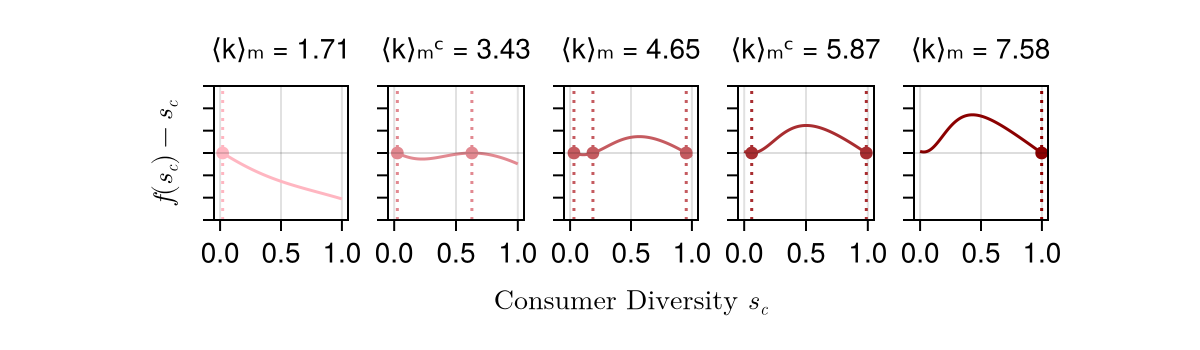

In [7]:
## bifurcation plot
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

λn = 4.0
#get critical points
λc_crit = MiNet.bifurcation_manifold(λn) |> sort

d = [λc_crit[1] / 2, λc_crit[1], mean(λc_crit), λc_crit[2],λc_crit[2] + λc_crit[1] / 2]

lc_vec = [[λn, l, 0.0] for l = d]
lm_vec = [[l, λn, 0.0] for l = d]

C_vec = [x -> F(x[1],x[2],l) for l = lc_vec]
M_vec = [x -> F(x[1],x[2],l) for l = lm_vec]



f = Figure(size = (600,175))
x_vec = range(0,1.0, length = 100)

for i = eachindex(d)
    ax = Axis(f[1,i], aspect = 1)
    hidedecorations!(ax, grid = false, ticks = false,ticklabels=false)
    hideydecorations!(ax, ticks=false)
    f_sol = MiNet.arrival_prop_funcs.(C_vec[i], M_vec[i])
    b1(x) = f_sol[:b](f_sol[:c](x)) - x

    c = resample_cmap(:reds, length(d))[i]
    style = d[i] ∈ λc_crit ? :dash : :solid

    #find solutions
    y_vec = b1.(x_vec)
    lines!(ax, x_vec, y_vec, color = c)

    sol = find_zeros(b1, -0, 1)
    scatter!(ax, sol, fill(0.0,length(sol)), color = c)
    vlines!(ax, sol, color = c, linestyle = :dot)
    
    hlines!(ax, 0.0, color = :black, linewidth = 0.1)
    
    if d[i] ∉ λc_crit
        Label(f[0,i], "⟨k⟩ₘ = $(round(d[i],digits = 2))")
    else
        Label(f[0,i], "⟨k⟩ₘᶜ = $(round(d[i],digits = 2))")
    end

    ylims!(ax, -0.75,0.75)
end

# linkyaxes!(f.content...)

Label(f[2,1:5],L"\text{Consumer Diversity} \ s_c")
Label(f[1,0 ],L"f(s_c) - s_c", rotation = pi/2, tellheight = false)

# [colsize!(f.layout, i, Auto()) for i = 1:5]
# resize_to_layout!(f)

colgap!(f.layout, 10)
rowgap!(f.layout, 10)

f

In [70]:
save("../Results/Figures/selfconsistency.svg", f)

CairoMakie.Screen{SVG}


# Consumer and Resource Supply

Next we consider what happens as we supply consumer or resources in the system. This is equivelent to fixing some proportion of the nodes states as persisting. 

In [181]:
A(X, s) = s + (1-s)*X # remove proportion s / keep proportion (s-1)
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

λn=4.0
λp=10.0

#generate p_list
n_s = 100
s_vec = range(0.0, 0.99, length = n_s)
ρ = 0.0

# p_mat = [([λn,λp, ρ*sqrt(λn*λp)], [λp,λn, ρ*sqrt(λn*λp)]) for λn = l_vec, λp = l_vec]

b0_s_sols = Matrix{Vector}(undef,n_s, n_s)
c0_s_sols = similar(b0_s_sols)

k = [0]

Threads.@threads for i = 1:n_s
    for j = 1:n_s
        
        k[1] += 1
        if k[1] % 100 == 0
            print("\r", k)
        end

        #remove eb - 1 species
        eb = s_vec[i]
        #supply ec resources
        ec = s_vec[j]

        B(x) = F(A(x[1], ec), A(x[2], ec),  [λn,λp,0.0]) 
        C(x) = F(A(x[1], eb), A(x[2], eb),  [λp,λn,0.0]) 

        b0,c0 = MiNet.solve_arrival_probs(B,C)
        
        
        b0_s_sols[i,j] = b0 
        c0_s_sols[i,j] = c0
    
    end
end

LoadError: cannot define function A; it already has a value

In [8]:
f = Figure(size = (1200,600))
ax = Axis(f[1,1], xlabel = "consumers removed", ylabel = "resources supplied")
axm = [Axis(f[1,1 + i]) for i = 1:3]

n_s = 100
s_vec = range(0.0, 0.99, length = n_s)


for i = 1:n_s
    for j = 1:n_s
        if length(b0_s_sols[i,j]) == 1
            scatter!(ax,s_vec[i], s_vec[j], color = b0_s_sols[i,j][1],colorrange = (0,1))
        else
            for k = 1:3
                scatter!(axm[k],s_vec[i],s_vec[j],color = b0_s_sols[i,j][k],colorrange = (0,1))
            end
        end
    end
end

ax = Axis(f[2,1], xlabel = "consumers removed", ylabel = "resources supplied")
axm = [Axis(f[2,1 + i]) for i = 1:3]

n_s = 100
s_vec = range(0.0, 0.99, length = n_s)

for i = 1:n_s
    for j = 1:n_s
        if length(b0_s_sols[i,j]) == 1
            scatter!(ax,s_vec[i],s_vec[j], color = c0_s_sols[i,j][1],colorrange = (0,1))
        else
            for k = 1:3
                scatter!(axm[k],s_vec[i],s_vec[j],color = c0_s_sols[i,j][k],colorrange = (0,1))
            end
        end
    end
end


linkaxes!(f.content...)

f

LoadError: UndefVarError: `b0_s_sols` not defined

In [873]:


# f = Figure()
# ax1 = Axis(f[1,1], title = "Consumers persisting")
# ax2 = Axis(f[1,2], title = "Resources persisting")

# Label(f[2,1:2], "Consumers Removed", tellheight = true)

# ax3 = Axis(f[3,1])
# ax4 = Axis(f[3,2])

# Label(f[4,1:2], "Resources Supplied", tellheight = true)


# for i = 1:20:n_s
#     yvec = b0_s_sols[:,i]
#     color = 1
    
#     plot_bifurcation!(ax1, s_vec, b0_s_sols[:,i], color = i, colorrange = (1,n_s))
#     plot_bifurcation!(ax2, s_vec, c0_s_sols[:,i], color = i, colorrange = (1,n_s))

#     plot_bifurcation!(ax3, s_vec, b0_s_sols[i,:], color = i, colorrange = (1,n_s))
#     plot_bifurcation!(ax4, s_vec, c0_s_sols[i,:], color = i, colorrange = (1,n_s))

# end
#     f

## supply simulations

In [878]:
#network size
N = 5000
#average degree: need produce covariance
λn,λp,λr = 4.0, 10.0, 0.0

n_r = 10

#create network and set initial state
g = MiNet.generate_network(N, λn, λp, λr);
c = fill(false, 2N)
c[1:N] .= true
s = fill(true, 2N);

b0_sim_sols = Array{Float64,3}(undef,n_s, n_s, n_r)
c0_sim_sols = similar(b0_sim_sols)

#create network and set initial state
g = MiNet.generate_network(N, λn,λp,λr);
c = fill(false, 2N)
c[1:N] .= true
s = fill(true, 2N);

rep = [0]
Threads.@threads for i = 1:n_s
    for j = 1:n_s

        c_copy = deepcopy(c)
        g_copy = deepcopy(g)
        
        k[1] += 1
        if k[1] % 100 == 0
            print("\r", k)
        end

        b_rm = sample(1:N, Int(floor(s_vec[i]*N)), replace = false)
        c_rm = sample(N+1:2N, Int(floor(s_vec[j]*N)), replace = false)

        to_rm = vcat(b_rm, c_rm)
        to_keep = filter( x -> x ∉ to_rm, 1:2N)

        rem_vertices!(g_copy, to_rm, keep_order = true)
        c_copy = c_copy[to_keep]
    
        for r = 1:n_r
            s = MiNet.get_state(g_copy, c_copy, rand(); Nt = 100, ts = false)
            b0_sim_sols[i,j,r] = mean(s[c_copy])
            c0_sim_sols[i,j,r] = mean(s[.!c_copy])
        end
    end
end

[69600]

## Plotting

In [77]:
res = load("../Results/JLD2/fig_2.jld2")
b0_sim,c0_sim = res["sim"]
b0_pred,c0_pred = res["pred"]

(Vector[[0.9998180861736164] [0.9998199084295254] … [0.9999963678802942] [0.9999981839714792]; [0.999798921566586] [0.9998009361205569] … [0.9999959858739742] [0.9999979929748536]; … ; [0.018589544577476944] [0.019357044707513007] … [0.9358081658470663] [0.9675750376789316]; [0.018451191546311783] [0.01920853202788408] … [0.9296959362676478] [0.9643289256841854]], Vector[[0.9999545174063224] [0.999954518235124] … [0.9999545984212278] [0.9999545992457544]; [0.9999497253369019] [0.999949726339574] … [0.99994982332397] [0.9999498243209857]; … ; [0.003711006049535004] [0.0038639246992090426] … [0.1706903184004166] [0.17594253096964552]; [0.0018434179687413232] [0.0019190095449290734] … [0.08877879319297499] [0.09192916614355695]])

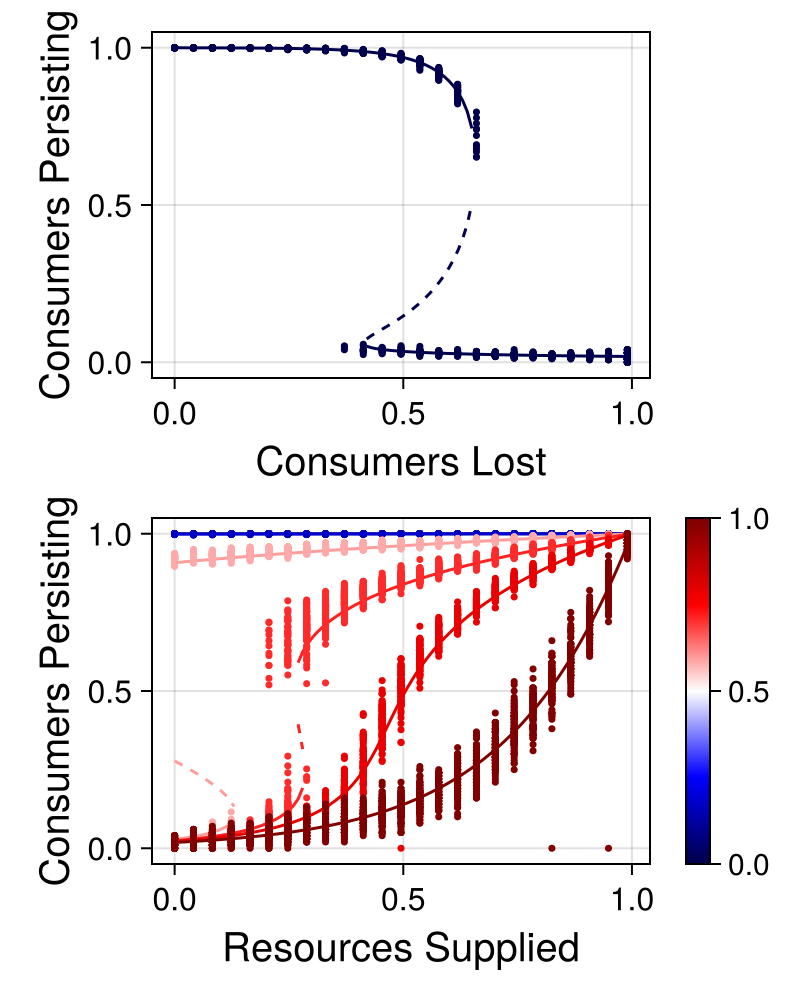

In [107]:
#Parameters
λn=4.0
λp=10.0

#generate p_list
n_s = 100
s_vec = range(0.0, 0.99, length = n_s)

#network simulations
#network size
n_s_network = 25
s_vec_network = range(0.0, 0.99, length = n_s_network)

N = 10000
n_r = 100
n_rep = 1

f = Figure(size = (400,500))

style = (xlabelsize = 20, ylabelsize = 20, xticklabelsize = 16, yticklabelsize = 16)

ax = Axis(f[1,1], xlabel = "Consumers Lost", ylabel = "Consumers Persisting"; style...)

#initial consumer bifurcation
c = resample_cmap(:seismic, n_s)[1]
series!(ax, s_vec_network, b0_sim[:,:,1,1], solid_color = c, linewidth = 0, markersize = 5)
plot_bifurcation!(ax, s_vec, b0_pred[:,1], color = c)


#varying consumer supply
ax2 = Axis(f[2,1], xlabel = "Resources Supplied", ylabel = "Consumers Persisting", ; style...)
for i = [1,20,60,72,80,100] 
    c = resample_cmap(:seismic, n_s)[i]
    plot_bifurcation!(ax2, s_vec, b0_pred[i,:], color = c)
end

for i =  [1,5,15,18,20,25] 
    c = resample_cmap(:seismic, n_s_network)[i]
    series!(ax2, s_vec_network, b0_sim[:,i,:,1], solid_color = c, linewidth = 0, markersize = 5)
end


Colorbar(f[2,2], colormap = :seismic, colorrange = (0,1), ticklabelsize = 15)

linkaxes!(ax,ax2)

# # save("../Results/Figures/removal_plots.pdf", f)

f

# Correlated

In [92]:
function plot_bifurcation!(ax, xvec, yvec; args...)
    if any(length.(yvec) .== 3)
        b_order = 0
        #if not all in the multistable
        if !all(length(yvec) .== 3)
            b_order = minimum(yvec[end]) < maximum(yvec[1]) ? :hl : :lh 
        else
            b_order = yvec[end][2] < yvec[1][2] ? :hl : :lh
        end
        #plot branches
        if b_order == :hl
            inde = findlast(length.(yvec) .== 3)
            lines!(ax, xvec[1:inde], maximum.(yvec[1:inde]); args...)
            
            inds = findfirst(length.(yvec) .== 3)
            lines!(ax, xvec[inds: end], minimum.(yvec[inds:end]); args...)
        
            lines!(ax, xvec[inds:(inde)], [y[2] for y = yvec[inds: (inde) ]]; linestyle = :dash, args...)
        elseif b_order == :lh
             inde = findlast(length.(yvec) .== 3)
            lines!(ax, xvec[1:inde], minimum.(yvec[1:inde]); args...)
            
            inds = findfirst(length.(yvec) .== 3)
            lines!(ax, xvec[inds: end], maximum.(yvec[inds:end]); args...)
        
            lines!(ax, xvec[inds:(inde)], [y[2] for y = yvec[inds: (inde) ]]; linestyle = :dash, args...)
        end
    else
        lines!(ax, xvec, [y[1] for y = yvec]; args...)
    end
end

plot_bifurcation! (generic function with 1 method)

In [129]:
#params
n_l = 50
l_vec = range(exp(1), 10.0, length = n_l)
n_cor = 6
cor_vec = range(0,1.0, length = n_cor) 

ρ = 0.0
N = 100
p_vec = [4.0]

1-element Vector{Float64}:
 4.0

In [389]:
res = load("../Results/JLD2/fig_cor.jld2")
b0_phase,c0_phase = res["phase"];
b0_sim,c0_sim = res["sim"]

b0_phase[isempty.(b0_phase)] .= Ref([])
b0_sim[isempty.(b0_sim)] .= Ref([]);

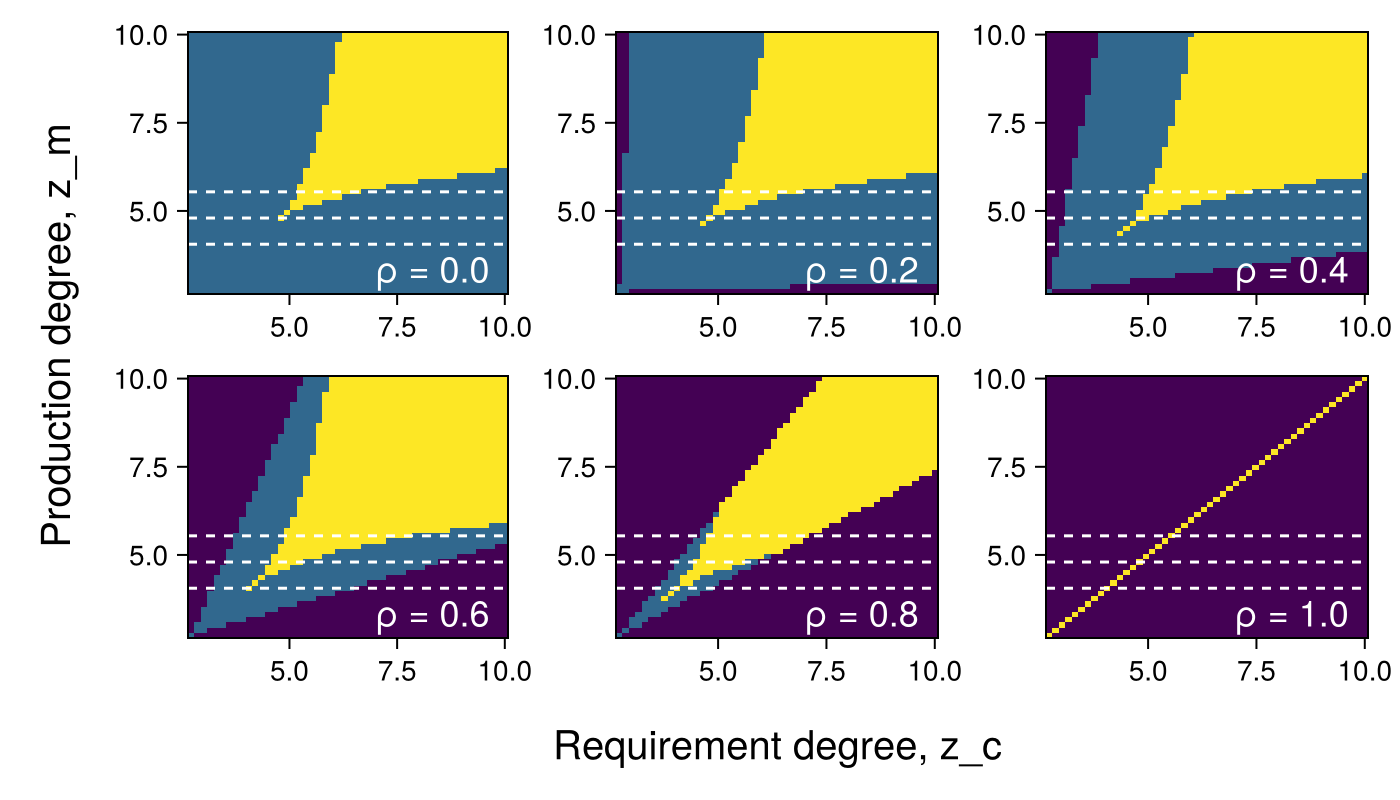

In [406]:
f = Figure(size = (700,400))

for i = 1:6
    ax = Axis(f[(i-1) ÷ 3, (i-1) % 3])
    heatmap!(ax,l_vec, l_vec, length.(b0_phase)[:,:,i], colorrange = (0,3))
    text!(7,2.75,text=string("ρ = ",cor_vec[i]), color = :white, fontsize = 18)
    hlines!(ax, l_vec[[10,15,20]], color = :white, linestyle = :dash)
end

Label(f[2,0:2], "Requirement degree, z_c", fontsize = 20)
Label(f[0:1,-1], "Production degree, z_m", rotation = pi/2, fontsize=20)

f

In [407]:
save("../Results/Figures/correlation_phase.svg", f)
save("../Results/Figures/correlation_phase.pdf", f)

CairoMakie.Screen{PDF}


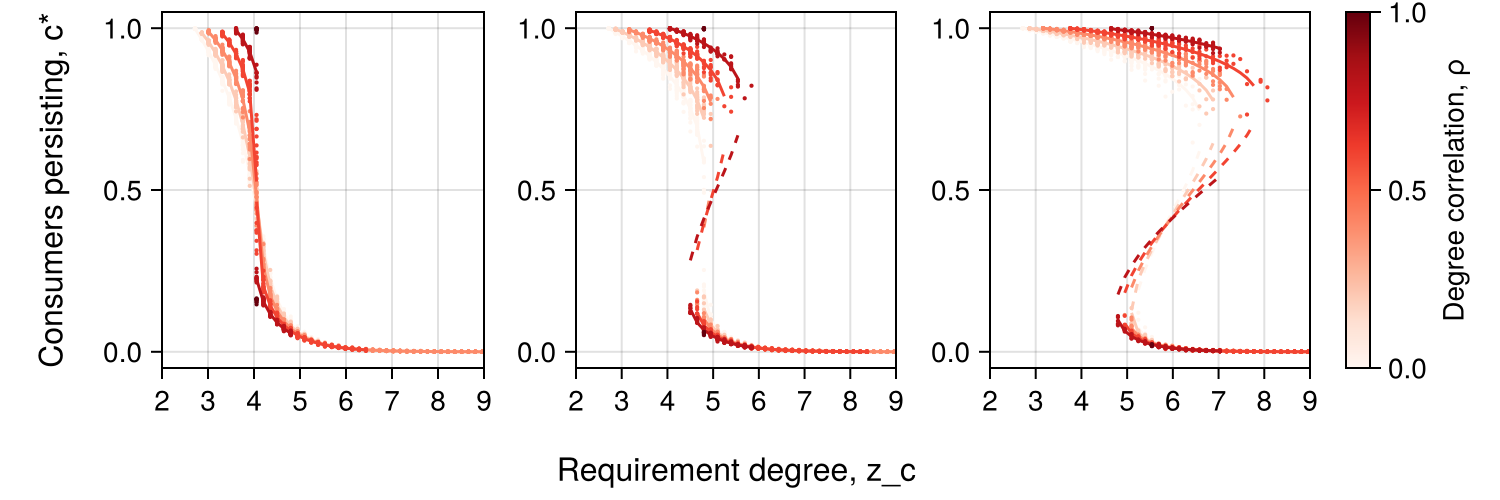

In [412]:
f = Figure(size=(750,250))

for (k,v) = enumerate([10,15,20])
    ax = Axis(f[1,k])
    xlims!(ax,2,9)
    n = v
    for i = 1:6
        c = resample_cmap(:Reds_9, 6)[i]
        ind = .!isempty.(b0_phase[:,n,i])
        plot_bifurcation!(ax,l_vec[ind], b0_phase[ind,n,i], color = c)
        for j = findall(ind)
            scatter!(ax, fill(l_vec[j], 20), vcat(b0_sim[j,n,i]...), color = c, markersize = 3)
        end
    end    
end

Colorbar(f[1,4], colorrange = (0,1), colormap = :Reds_9, label = "Degree correlation, ρ")

Label(f[2,1:3], "Requirement degree, z_c", fontsize = 16)
Label(f[1,0], "Consumers persisting, c*", rotation = pi/2, fontsize = 16)

f

In [413]:
save("../Results/Figures/correlation_bifurcation.svg", f)
save("../Results/Figures/correlation_bifurcation.pdf", f)

CairoMakie.Screen{PDF}


In [226]:

b0_sim[:,20,2]

50-element Vector{Vector}:
 Any[]
 [0.9988]
 [0.9946]
 [0.99]
 [0.9854]
 [0.9826]
 [0.971]
 [0.9736]
 [0.9672]
 [0.966]
 [0.9582]
 [0.94]
 [0.947]
 ⋮
 [0.0004]
 [0.0002]
 [0.0002]
 [0.0006]
 [0.0002]
 [0.0002]
 [0.0]
 [0.0002]
 [0.0]
 [0.0]
 [0.0]
 [0.0002]

In [179]:
f = Figure(size = (1000,200))

[heatmap!(Axis(f[1,i]), maximum.(b0_sim)[:,:,i]) for i = 1:5]

f

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [31]:
# correlates predictions
#bivarate poisson PGF
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

#generate params list
p_mat = Array{Any,3}(undef,n_l,n_l,n_l)#[([λn - r, λp - r, r], [λp - r,λn - r, r]) for λn = l_vec, λp = l_vec, r = r_vec]

for i = 1:n_l
    for j = 1:n_l
        for k = 1:n_l
            #get parameter combinations
            
        end
    end
end


# b0_sols = Matrix{Vector}(undef,n_l, n_l)
# c0_sols = similar(b0_sols)

# k = [0]
# Threads.@threads for i = 1:n_l
#     for j = 1:n_l
#         k[1] += 1
#         if k[1] % 100 == 0
#             print("\r", k)
#         end
        
#         B(x) = F(x[1],x[2], p_mat[i,j][1])
#         C(x) = F(x[1],x[2], p_mat[i,j][2])

#         b0,c0 = MiNet.solve_arrival_probs(B,C)

#         b0_sols[i,j] = b0 
#         c0_sols[i,j] = c0 
#     end
# end


100×100×100 Array{Any, 3}:
[:, :, 1] =
 #undef  #undef  #undef  #undef  #undef  …  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  …  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  …  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef     #undef  #undef  #

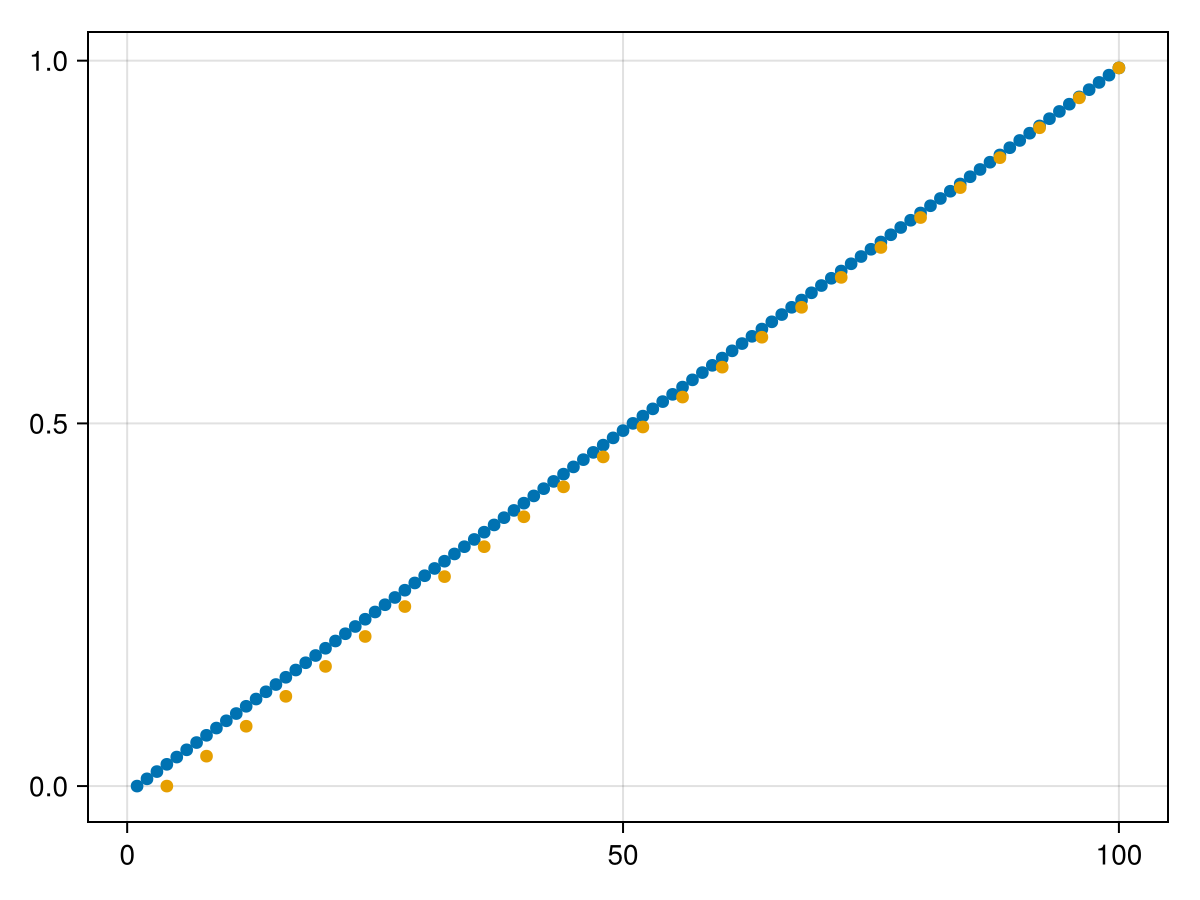

In [116]:
f,ax = plot(1:100, s_vec)
plot!(4*(1:25), s_vec_network)
f

# Network Plot

In [41]:
Random.seed!(2)

N = 100

λn,λp,λr = 1.0,2.0,0.0

g = MiNet.generate_network(N,MiNet.joint_sample_cheat, λn,λp,λr);
c = vcat(fill(true, N), fill(false,N))
s = sl = MiNet.get_state(g, c, 0.7)

cond_ind = connected_components(g)[1]
rem_vertices!(g, findall(1:2N .∉ Ref(cond_ind)), keep_order = true)

s = s[cond_ind]
c = c[cond_ind]

MiNet.graphviz(g,s,c,"../Results/graphs/graph.dot", "../Results/Figures/graph.pdf")


Process(`dot -Tpdf ../Results/graphs/graph.dot`, ProcessExited(0))

In [42]:
include("../Code/MiNet.jl")
MiNet.graphviz_bipartite(g,s,c,"../Results/graphs/graph.dot", "../Results/Figures/graph_bi.pdf")

0.0
0
0.10752688172043012
0
0.21505376344086025
0
0.3225806451612903
0
0.4301075268817205
0
0.5376344086021505
0
0.6451612903225806
0
0.7526881720430108
0
0.860215053763441
0
0.967741935483871
0
1.075268817204301
0
1.1827956989247312
0
1.2903225806451613
0
1.3978494623655913
0
1.5053763440860215
0
1.6129032258064515
0
1.720430107526882
0
1.827956989247312
0
1.935483870967742
0
2.043010752688172
0
2.150537634408602
0
2.258064516129032
0
2.3655913978494625
0
2.4731182795698925
0
2.5806451612903225
0
2.6881720430107525
0
2.7956989247311825
0
2.903225806451613
0
3.010752688172043
0
3.118279569892473
0
3.225806451612903
0
3.333333333333333
0
3.440860215053764
0
3.548387096774194
0
3.655913978494624
0
3.763440860215054
0
3.870967741935484
0
3.978494623655914
0
4.086021505376344
0
4.193548387096774
0
4.301075268817204
0
4.408602150537634
0
4.516129032258064
0
4.623655913978494
0
4.731182795698925
0
4.838709677419355
0
4.946236559139785
0
5.053763440860215
0
5.161290322580645
0
5.2688172043010

Process(`dot -Tpdf ../Results/graphs/graph.dot`, ProcessExited(0))

# Alternative network structures

## Additional modularity
Metabolites are split into groups. Consumers release metabolites based on the metabolites they consume. They are more likely to release metabolites to a given group if they consumer lots of them.

In [218]:
using Distributions 

# test with network structure
N = 1000
M = 1000
λn,λp,λr = 3.0, 3.0, 1.0

function modular_communtiy(N,λn,λp,λr)
    #inital sample
    X = rand(Poisson(λn-λr),N)
    Y = rand(Poisson(λp-λr),N)
    R = rand(Poisson(λr),N)
    
    #get consumer degree
    Kci = X .+ R
    Kco = Y .+ R
    
    #label consumer uptake links
    Kci_lab = rand.(Ref(1:5), Kci)
    Kco_lab = [length(Kci_lab[i]) > 0 ? sample(Kci_lab[i], Kco[i]) : rand(1:5, Kco[i]) for i = 1:N]
    
    #get in and out module numbers: how many links leave and enter each module
    n_D_source = vcat(Kci_lab...)
    Do = [sum(n_D_source .== unique(n_D_source)[i]) for i = 1:5] 
    p_D_dest = vcat(Kco_lab...)
    Di = [sum(p_D_dest .== unique(p_D_dest)[i]) for i = 1:5] 
    
    #sample individual resource links based on total module numbers
    Kmi = [rand(Multinomial(Do[i], 200)) for i = 1:5]
    Kmo = [rand(Multinomial(Di[i], 200)) for i = 1:5]

    #assemble network
    #get the need link destinations
    n_dest = inverse_rle(1:N, Kci)
    n_source = [inverse_rle( 200*(i-1) .+ (1:200), Kmo[i]) |> shuffle for i = 1:5]
    n_src = zeros(Int, length(n_D_source))
    for i = eachindex(n_D_source)
        n_src[i] = n_source[n_D_source[i]][1]
        circshift!(n_source[n_D_source[i]], -1)
    end
    
    #assemble network
    #get the need link destinations
    p_source = inverse_rle(1:N, Kco)
    p_dest = [inverse_rle( 200*(i-1) .+ (1:200), Kmi[i]) |> shuffle for i = 1:5]
    p_dst = zeros(Int, length(p_D_dest))
    for i = eachindex(p_D_dest)
        p_dst[i] = p_dest[p_D_dest[i]][1]
        circshift!(p_dest[p_D_dest[i]], -1)
    end

    g = DiGraph(2N)

    l_n = Pair.(n_src, n_dest .+ N)
    add_edge!.(Ref(g), l_n)
    
    l_p = Pair.(p_source .+ N, p_dst)
    add_edge!.(Ref(g), l_p)
    
    return(g)
end

modular_communtiy (generic function with 1 method)

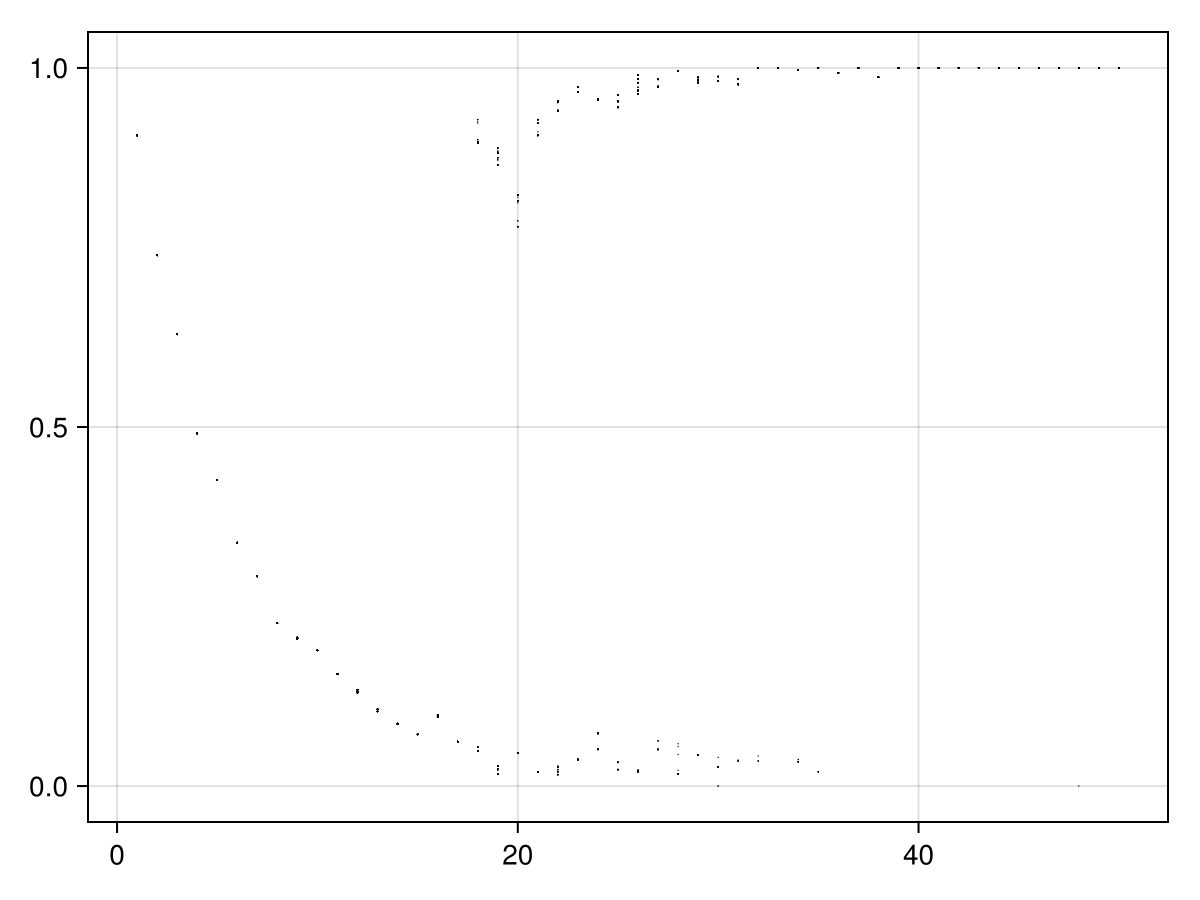

In [301]:
N = 1000
Nrep = 100
Nl = 50

l_vec = range(0.1,10.0, length = Nl)
res = Array{Any,3}(undef,Nl,Nrep,2)

Threads.@threads for i = 1:Nl
    λn = l_vec[i]
    g = modular_communtiy(N,λn,4.0,0.0)
    for j = 1:Nrep
       
        c = fill(false, 2N)
        c[1:N] .= true
        s = MiNet.get_state(g, c, rand())
        res[i,j,1] = mean(s[1:N])
        res[i,j,2] = mean(s[(N+1) : end])
    end
end

series(res[:,:,1]', solid_color = :black, linewidth = 0, markersize = 1)

## Core-periphery 
Consumers tend to share needs for a few select resources. If equivelent to having a skewed degree distribution. 

# niche model
What if resources and consumers are placed along a niche axis?


In [298]:
function niche_community(N,λn,λp)
    ax_c = rand(N) |> sort
    ax_m = rand(N) |> sort
    
    d_mat = ax_c .- ax_m'
    
    k_c = rand(Poisson(λn), N)
    k_m = rand(Poisson(λp), N)
    
    g = SimpleDiGraph(2N)
    
    for i = 1:N
        #add consumption
        for a = sortperm(abs.(d_mat[i,:]))[1:k_c[i]]
            add_edge!(g, Pair(N + a, i))
        end
        #add production
        j = findmin(abs.(d_mat[:,1] .- 0.1))[2] 
        for a = 1:k_m[i]
            add_edge!(g, Pair(j + a - 1, i + N))
        end
    end
    return(g)
end


niche_community (generic function with 1 method)

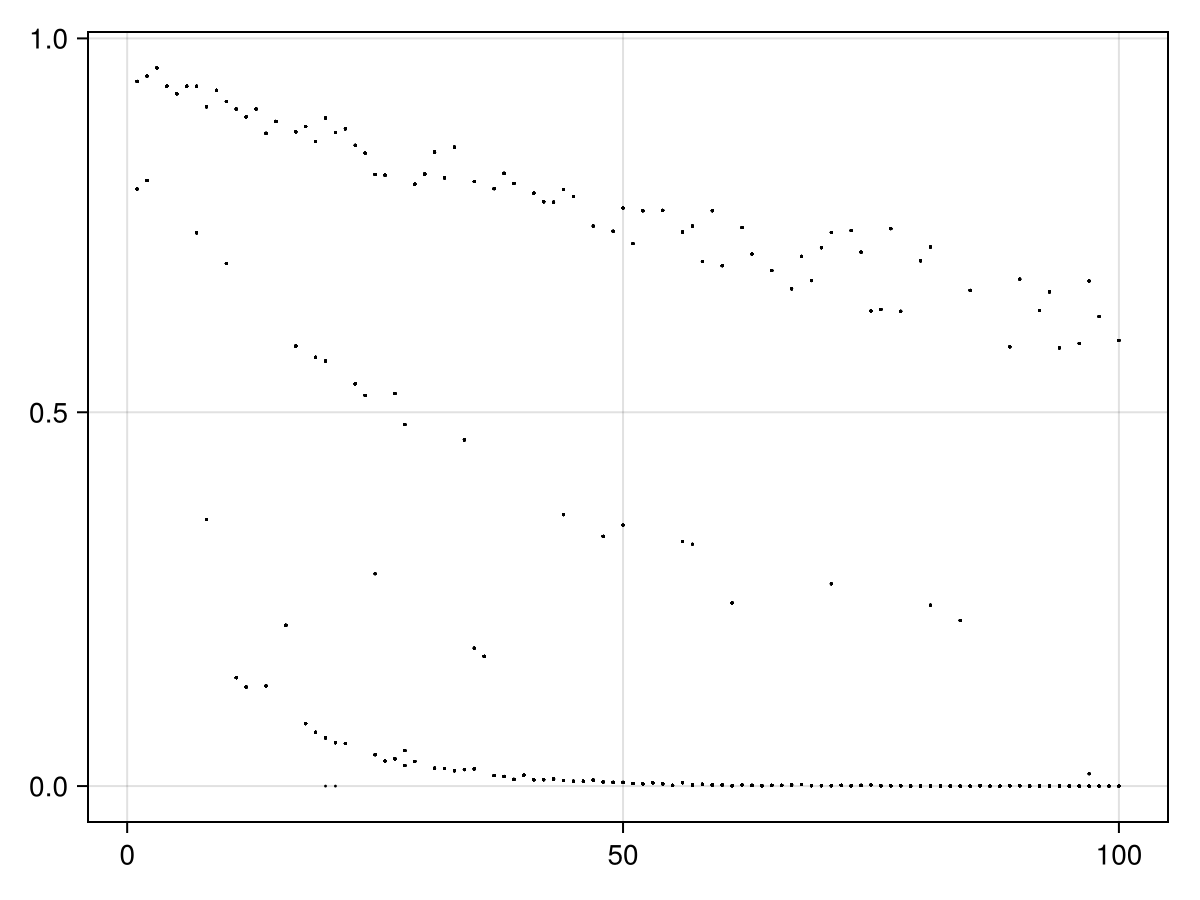

In [310]:
N = 2000
Nrep = 100
Nl = 100

l_vec = range(1,10.0, length = Nl)
res = Array{Any,3}(undef,Nl,Nrep,2)

Threads.@threads for i = 1:Nl
    λn = l_vec[i]
    g = niche_community(N,λn,3.0)
    
    for j = 1:Nrep
       
        c = fill(false, 2N)
        c[1:N] .= true
        s = MiNet.get_state(g, c, rand())
        res[i,j,1] = mean(s[1:N])
        res[i,j,2] = mean(s[(N+1) : end])
    end
end

series(res[:,:,1]', solid_color = :black, linewidth = 0, markersize = 2)